In [48]:
from gsdmm import MovieGroupProcess
import numpy as np
import pandas as pd
import re
import spacy
from spacy.tokenizer import Tokenizer
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import googletrans
from googletrans import Translator
from langdetect import detect
import matplotlib.pyplot as plt
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel

In [5]:
df = pd.read_csv('../libs/facebook_ad_Senate_v2.csv')
print("Ads data shape : ", end = " ") ; print(df.shape)
df.dropna(subset=['candidate'], inplace=True)
print("\n%s rows remaning after dropping 'nan' candidates"%(df.shape[0]))

Ads data shape :  (1002439, 30)

48087 rows remaning after dropping 'nan' candidates


In [7]:
df[['funding_entity','ad_body_text','ad_link_caption','ad_link_description','ad_link_title','impressions_upper']].isna().sum()


funding_entity           456
ad_body_text             309
ad_link_caption         8984
ad_link_description    13373
ad_link_title           9041
impressions_upper        106
dtype: int64

In [155]:
ad_text = df['ad_body_text'].unique()

In [10]:
translator = Translator()
for i, text in enumerate(ad_text):
    try:
        language = detect(text)
        if language=='es':
            text_english = translator.translate(text).text
            ad_text[i] = text_english
    except:
        continue;

In [144]:
# months = ['january', 'february', 'march', 'april', 'may', 'june', \
#           'july', 'august', 'september', 'october', 'november', 'december']
# months_regex = re.compile(r'\b%s\b' % r'\b|\b'.join(map(re.escape, months)))

In [11]:
# regex to remove state names
state_names = df.state.unique()
state_names = [i.lower() for i in state_names]

# regex to remove candidate names
candidate_names = [i.lower() for i in df.candidate.unique()]
candidate_names = candidate_names + ([i.split(' ')[1] for i in candidate_names])
candidate_names = candidate_names + ([i.split(' ')[0] for i in candidate_names])
candidate_names = list(set(candidate_names))

# regex to replace month by 'month'
# months = ['january', 'jan', 'february', 'feb', 'march', 'mar', 'april', 'may', 'june', \
#           'july', 'august', 'aug', 'september', 'sept', 'october', 'oct', 'november', 'nov', 'december']

# months_regex = re.compile(r'\b%s\b' % r'\b|\b'.join(map(re.escape, months)))
state_regex = re.compile(r'\b%s\b' % r'\b|\b'.join(map(re.escape, state_names)))
candidate_regex = re.compile(r'\b%s\b' % r'\b|\b'.join(map(re.escape, candidate_names)))


In [27]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
stemmer = PorterStemmer() 
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = str(text).lower()
    text = state_regex.sub('', text)
    text = candidate_regex.sub('', text)
#     text = months_regex.sub('month', text)
    text = re.sub(r'\bhttp[s]?:[\w\W]+\b','link',text)
    text = re.sub(r'\b[a-zA-Z\.]+.com/[a-zA-Z]+\b','link',text)
    text = re.sub(r'[^A-Za-z0-9 ]+', ' ', text)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
#     stem_words=[stemmer.stem(w) for w in filtered_words]
#     lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return filtered_words

In [156]:
docs = [preprocess(i) for i in ad_text]

In [35]:
# data_array = []

# for i, text in enumerate(docs):
#     if len(text)<=6:
#         text = text + ['padd']*(7-len(text))
#     data_array.append([i, ' '.join(text)])

data_text = []
for i, text in enumerate(docs):
    data_text.append(' '.join(text))

file1 = open("MyFile.txt","w") 
for line in data_text:
    file1.write(line)
    file1.write("\n")
file1.close() 

In [36]:
ad_text = []
count=0
with open('MyFile.txt', 'r') as reader:
    for line in reader:
        if not line.isspace():
            ad_text.append(line)
        else:
            print(count)
        count += 1
            
len(ad_text)

1446
1638


7067

In [157]:
vocab = set([x for doc in docs for x in doc])
n_terms = len(vocab)

In [32]:
def loadGloveModel(File):
    print("Loading Glove Model")
    f = open(File,'r')
    gloveModel = {}
    for line in f:
        splitLines = line.split()
        word = splitLines[0]
        wordEmbedding = np.array([float(value) for value in splitLines[1:]])
        gloveModel[word] = wordEmbedding
    print(len(gloveModel)," words loaded!")
    return gloveModel

glove = loadGloveModel('../../glove.6B.100d.txt')

Loading Glove Model
400000  words loaded!


In [34]:
not_in_glove = []
for i in vocab:
    if i not in glove:
        not_in_glove.append(i)
print(len(not_in_glove))

935


In [39]:
dictionary = Dictionary(docs)
corpus = [dictionary.doc2bow(text) for text in docs]

In [164]:
def calculate_coherence(model, num_topics, top_n_words=20):
    cluster_top_words = top_words(model.cluster_word_distribution, range(num_topics), top_n_words, False)
    cm = CoherenceModel(topics=cluster_top_words, corpus=corpus, dictionary=dictionary, texts=docs,coherence='c_uci')
    return cm.get_coherence()
    

In [269]:
def create_model(docs, clusters=15, iters=10, top_n_words=5):
    mgp = MovieGroupProcess(K=clusters, alpha=0.1, beta=0.1, n_iters=iters)
    y = mgp.fit(docs, n_terms)
    doc_count = np.array(mgp.cluster_doc_count)
    print('Number of documents per topic :', doc_count)
    print('*'*20)
    # Topics sorted by the number of document they are allocated to
    top_index = doc_count.argsort()[::-1]
    print('Most important clusters (by number of docs inside):', top_index)
    print('*'*20)
    # Show the top n words in term frequency for each cluster 
    top_words(mgp.cluster_word_distribution, top_index, top_n_words)
    return mgp

def top_words(cluster_word_distribution, top_cluster, values, print_=True):
    result = []
    for cluster in top_cluster:
        try:
            sort_dicts =sorted(cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        except: 
            sort_dicts =sorted(cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)
        if print_:
            print('Cluster %s : %s'%(cluster,sort_dicts))
            print(" — — — — — — — — — ")
        top_words = [key for key, value in sort_dicts]
        #print(top_words)
        result.append(top_words)
        
    return result

Create model by passing the number of clusters

In [270]:
test1 = create_model(docs, clusters=15)



In stage 0: transferred 6028 clusters with 15 clusters populated
In stage 1: transferred 2625 clusters with 15 clusters populated
In stage 2: transferred 1442 clusters with 15 clusters populated
In stage 3: transferred 989 clusters with 15 clusters populated
In stage 4: transferred 750 clusters with 15 clusters populated
In stage 5: transferred 612 clusters with 15 clusters populated
In stage 6: transferred 548 clusters with 15 clusters populated
In stage 7: transferred 564 clusters with 15 clusters populated
In stage 8: transferred 520 clusters with 15 clusters populated
In stage 9: transferred 541 clusters with 15 clusters populated
Number of documents per topic : [  91  137  494   89  972 1392  181  431  121  157  240  603  750 1040
  371]
********************
Most important clusters (by number of docs inside): [ 5 13  4 12 11  2  7 14 10  6  9  1  8  0  3]
********************
Cluster 5 : [('link', 224), ('senator', 224), ('people', 202), ('families', 197), ('support', 194)]
 — — —

In [271]:
print(calculate_coherence(test1, 15))


-0.7984017589849608


Name the clusters in the cluster_name list and create a dataframe 

In [272]:
cluster_names = ['immigration', 'support trump', 'join campaign(details)', 'voting details', 'cluster 4', 'vote early',
                'kavanaugh', 'health care', 'economy and energy', 'tax/charlotte', 'join support', 'campaign fight back', 'tax', 
                 'cluster 12', 'veteran']

assigned_cluster = pd.DataFrame(columns=('cluster','adtext'))
mgp = test
for i, doc in enumerate(docs):
    scores = mgp.score(doc)
    topic = cluster_names[np.argmax(scores)]
    assigned_cluster.loc[i] = [topic, ad_text[i]]

In [273]:
pd.options.display.max_colwidth = None
start_index = 0 
stop_index = 10 
cluster_index = 2
topic_df = assigned_cluster[assigned_cluster.cluster==cluster_names[cluster_index]].reset_index(drop=True)
topic_df.iloc[max(0, start_index): min(stop_index, assigned_cluster.shape[0])]

cluster  \
0  join campaign(details)   
1  join campaign(details)   
2  join campaign(details)   
3  join campaign(details)   
4  join campaign(details)   
5  join campaign(details)   
6  join campaign(details)   
7  join campaign(details)   
8  join campaign(details)   
9  join campaign(details)   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        adtext  
0                                                                                                                                                                                                                                                                                                                                                                                                         Join fellow volunteers and supporters on Election Night at Strangeways to watch the results roll in!  
1                                                                         Join us for an organizing rally where we will meet fellow supporters in the area, hear a special update from the campaign, and leave with specific next steps on how every person can get to work to elect Beto! (Beto will not be in attendance)\n\nDate: Saturday, July 28 \nTime: 3 p.m. - 5 p.m.\nLocation: EinStein's Pub\n873 S Mason Rd\nKaty, TX 77450\n\nRSVP: https://act.betofortexas.com/event/action/7628?source=fb1807  
2  Join us for an organizing rally in East Houston where we will meet fellow supporters in the area and leave with specific next steps on how every person can get to work to elect Beto! The location is TBD, if you have recommendations on location please email organizing@betofortexas.com (Beto will not be in attendance)\n\nDate: Saturday, June 30\nTime: 7:00 PM - 9:00 PM CDT\nLocation: TBD\n\nRSVP: RSVP: https://secure.betofortexas.com/page/event/detail/organizingmeeting/4jl3r?source=fb1806  
3                                                                                                                                                                             Join us for our official Dallas Office Opening Party where we will meet fellow supporters in the area, find out how to get involved with the campaign, and hear from Beto himself! There will be food and music, so please RSVP and bring as many friends and family as you can to meet Beto and see our newest campaign office!  
4                                                                                                                                                                                                                                                             Don't miss your chance to see Trump Jr. and Kimberly Guilfoyle in Bozeman tomorrow, Tuesday, 9/25!! Get your FREE tickets NOW: https://www.eventbrite.com/e/donald-trump-jr-and-kimberly-guilfoyle-campaign-rally-in-bozeman-tickets-50397298677  
5                                                                                                                                                                                                                                                                                                                         TUESDAY: You're invited to join me for a rally in Uvalde!\r\n\r\nTickets are FREE, but you must RSVP: https://www.eventbrite.com/e/ted-cruz-uvalde-gotv-bus-stop-tickets-51742198308  
6                                                          Join us for an organizing rally where we will meet fellow supporters in the area, hear a special update from the campaign, and leave with specific next steps on

Ad Title analysis

## LFDMM and GPUDMM

In [274]:
model_name = 'gpudmm_new_data'
filename= '../../STTM/results/' + model_name + '.'

with open(filename+'topicAssignments', 'r') as reader:
    topic_assignment_text = reader.readlines()
    
with open(filename+'topWords', 'r') as reader:
    top_words = reader.readlines()
    
actual_text = []
tokenized_text = []
i=0
with open('../../STTM/dataset/MyFile.txt', 'r') as reader:
    for line in reader:
        if not line.isspace():
            actual_text.append(ad_text[i])
            tokenized_text.append(line)
        else:
            actual_text.append('N/A')
        i += 1

In [275]:
tokenized_text  = [i.split(' ')[:-1] for i in tokenized_text]
top_words = [i.split(' ')[:10] for i in top_words]
dictionary = Dictionary(tokenized_text)
corpus = [dictionary.doc2bow(text) for text in tokenized_text]


cm = CoherenceModel(topics=top_words, corpus=corpus, dictionary=dictionary, texts=tokenized_text, coherence='c_uci')
cm.get_coherence()

-0.2671903118321898

In [276]:
print(f"Len of topics assignments: {len(topic_assignment_text)}")
print(f"Len of ads: {len(ad_text)}")

Len of topics assignments: 7067
Len of ads: 7069


In [277]:
ad_topic_df = pd.DataFrame(columns=('text', 'topic_index'))
j = 0
for i in range(len(ad_text)):
    if actual_text[i]=='N/A':
        ad_topic_df.loc[i, 'topic_index'] = 'N/A'
        j -= 1
    else:
        ad_topic_df.loc[i, 'text'] = actual_text[i]
        topic_array = topic_assignment_text[j].split(' ')[:-1]
#         topics = [int(k)-20 for k in topic_array if int(k)>19]
        topics = list(set(topic_array))
        
        try:
            ad_topic_df.loc[i, 'topic_index'] = topics[0]
        except:
            ad_topic_df.loc[i, 'topic_index'] = np.nan
    j += 1   

In [278]:
gpudmm_topics = ['unclear',
                'immigration',
                'unclear', 
                'Early voting', 
                'unclear',
                'unclear',
                'Donate', 
                'Join rally',
                'Kavanaugh',
                'unclear',
                'Healthcare cost, law and order',
                'Meet the candidate',
                'unclear',
                'Vote',
                'unclear',
                'Donate',
                'Fill survey/ join campaign',
                'Join campaign',
                'Healthcare',
                'unclear']

len(gpudmm_topics)
    

20

In [280]:
pd.options.display.max_colwidth = None
ad_topic_df[ad_topic_df.topic_index=='0'][0:5]

text  \
22                                                                                                                                                                                                                                                                                                                                                                                                                        BREAKING: Trump told an annual NRA convention that Bill Nelson “should be voted out of office immediately” – and now Trump and the NRA are throwing everything they’ve got into trying to defeat Bill Nelson and turn Florida red!\r\n\r\nThey know that if Bill Nelson loses in Florida, Democrats have NO chance of taking back the Senate. So a group of donors just offered to DOUBLE every gift we receive to fight back – but time is running out, and we’re falling $2,800 short of our match goal. We can’t stop Trump and the NRA unless grassroots donors like you give NOW and get every dollar doubled to protect Florida’s blue Senate seat!   
27                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            BREAKING: New NBC poll says Arizona’s toss-up Senate race is “neck and neck.”\n\nDonate to Democratic candidate Kyrsten Sinema today.   
40                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 Polls say Arizona’s toss-up Senate race is a dead heat, and experts like Nate Silver call it one of the most important elections in the country.\n\nChip in today to Democrat Kyrsten Sinema before voting begins on October 10:   
46  BREAKING: Brett Kavanaugh has made it very clear that he should not serve a lifetime appointment on the Supreme Court, but GOP Sen. Dean Heller has said he has "no reservations" about confirming Brett Kavanaugh and just last week called allegations against him "a little hiccup."\r\n\r\nDean Heller is also the ONLY GOP senator up for reelection in a state Donald Trump lost, and I’m running to defeat him. But right now, a recent poll shows me trailing by 1, and POLITICO says Democrats have “almost no shot” to take back the Senate and stop the GOP if we lose in Nevada.\r\n\r\nThat’s why a generous group of donors has offered to TRIPLE every dollar to flip this seat blue and take back the Senate for Democrats before our critical FEC deadline at 11:59 p.m. on Sept. 30! With time running out, we’re still falling short of our $300,000 goal – 

In [287]:
print(f"Unclear cluster size: {ad_topic_df[ad_topic_df.topic_index.isin(['0','2','4','5','9','12','14','19'])].shape[0]}")

Unclear cluster size: 3098


In [120]:
# lfdmm_topics = ['health care, violence against women', 
#                 'historic elections, donate', 
#                 'security, border security, immigration, gun violence',
#                 'donate/fund-raising',
#                 'join campaign',
#                 'show support',
#                 'kavanaugh, standing for women, trump',
#                 'donate, kavanaugh, blue wave in south',
#                 'economic issues',
#                 'join rally',
#                 'cheer for debate,renewable energy, support, unclear',
#                 'unclear',
#                 'join townhall, vote early',
#                 'important election (polls), republicans using money to win',
#                 'join facebook group, volunteer to make calls',
#                 'early voting',
#                 'raise money, donate',
#                 'veterans, mental health, taxes',
#                 'walt disney, unknown',
#                 'education, unknown']

In [281]:
ad_text_to_topic = {i:j for (i,j) in zip(ad_topic_df['text'], ad_topic_df['topic_index'])}


In [282]:
for i in range(df.shape[0]):
    try:
        df.loc[i,'topic_index'] = ad_text_to_topic[df.loc[i,'ad_body_text']]
        df.loc[i,'topic'] = gpudmm_topics[int(df.loc[i,'topic_index'])]
    except:
        continue
    

In [290]:
ad_topic_df.to_csv('../libs/ad_text_gpudmm_topics.csv')

In [263]:
df.topic.value_counts()

unclear                           18541
Donate                             8578
Early voting                       4169
Kavanaugh                          3905
Healthcare                         3526
Vote                               2427
Healthcare cost, law and order     2153
immigration                        1516
Meet the candidate                 1305
Join campaign                       769
Join rally                          520
Fill survey/ join campaign          358
Name: topic, dtype: int64

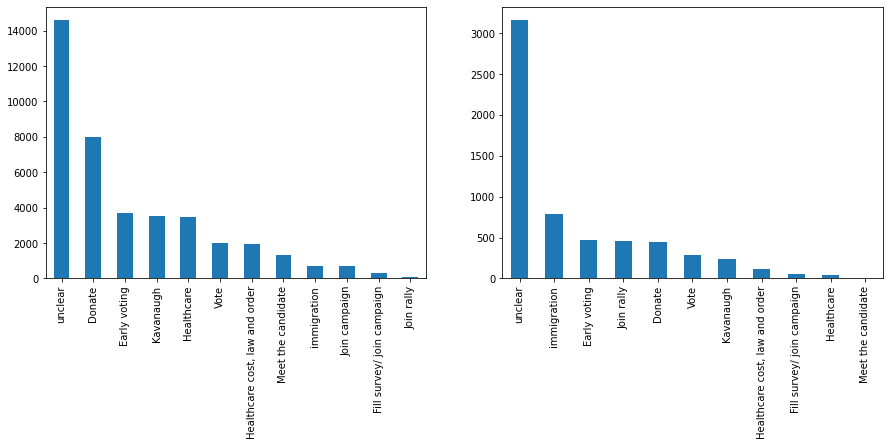

In [264]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

democrats = df[df.party=='Democratic']
republican = df[df.party=='Republican']

democrats.topic.value_counts().plot(kind='bar', ax=ax[0])
republican.topic.value_counts().plot(kind='bar', ax=ax[1])

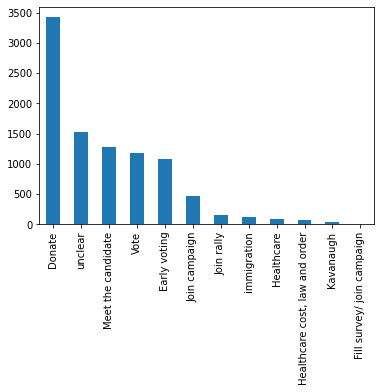

In [266]:
state = 'Washington'

df[df.state=='Texas'].topic.value_counts().plot(kind='bar')
plt.show()